In [1]:
import pandas as pd
bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd18adade80>]], dtype=object)

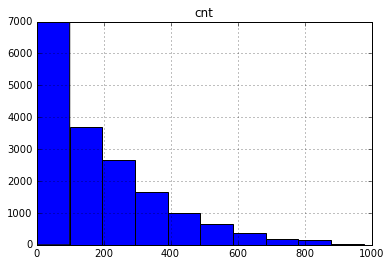

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
bike_rentals.hist("cnt")

In [12]:
bike_rentals = bike_rentals.drop(["casual", "registered"], axis=1)

In [29]:
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
cnt           1.000000
time_label   -0.378318
Name: cnt, dtype: float64

In [15]:
def assign_label(hour):
    if hour >= 6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour < 24:
        return 3
    else:
        return 4

bike_rentals["time_label"] = bike_rentals.apply(lambda row: assign_label(row["hr"]), axis=1)

Try mean squared error as error metric since cnt is not binary.  Can test with k-fold cross validation.

In [28]:
train = bike_rentals.sample(frac=0.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [90]:
columns = list(train.columns)
columns.remove("cnt")
columns.remove("dteday")
columns.remove("instant")
columns.remove("holiday")
columns.remove("weekday")
columns.remove("workingday")
columns

['season',
 'yr',
 'mnth',
 'hr',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

Not using holiday, weekday, workingday because low correlations.

In [33]:
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error

In [91]:
model = LinearRegression()
model.fit(train[columns], train["cnt"])
preds = model.predict(test[columns])
mse = mean_squared_error(test["cnt"], preds)
mse**0.5

138.89842636425374

In [92]:
bike_rentals[bike_rentals["cnt"] < 140].shape[0]/bike_rentals.shape[0]

0.4944473214799471

Given that nearly 50% of counts are less than 140, a mse of 139 gives a very unreliable estimator during 50% of the time.

In [93]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(train[columns], train["cnt"])
preds = tree.predict(test[columns])
mse1 = mean_squared_error(test["cnt"], preds)
mse1**0.5

116.91815054527463

In [94]:
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(train[columns], train["cnt"])
preds = tree.predict(test[columns])
mse2 = mean_squared_error(test["cnt"], preds)
mse2**0.5

95.639425382640482

In [101]:
tree = DecisionTreeRegressor(max_depth=9, min_samples_leaf=50)
tree.fit(train[columns], train["cnt"])
preds = tree.predict(test[columns])
mse2 = mean_squared_error(test["cnt"], preds)
mse2**0.5

93.879180670939476

In [103]:
print(mse2/mse1)
bike_rentals[bike_rentals["cnt"] < 100].shape[0]/bike_rentals.shape[0]

0.644725291913


0.40336037746705794

Was able to cut smse down by 35% with decision tree logic.  The error is still rather large consider the statistics of days with a count of < 100.

In [104]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(min_samples_leaf=5)
forest.fit(train[columns], train["cnt"])
preds = forest.predict(test[columns])
mse3 = mean_squared_error(test['cnt'], preds)
mse3**0.5

87.62633390670149

Reduces error a little more than the single decision tree.

In [ ]:
numpy.mean((preds-test['cnt'])**2)